# Integrate/aggregate signals across spatial layers

In this notebook, we will describe some usage principles for the *aggregate* method.

Let's first import some useful libraries and create some dummy data to show the example.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext jupyter_black

In [2]:
import os

os.environ["USE_PYGEOS"] = "0"

In [3]:
import spatialdata_plot
from spatialdata.datasets import blobs

In [4]:
sdata = blobs()
sdata

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/shapely/predicates.py:853: RuntimeWarning: invalid value encountered in overlaps
  return lib.overlaps(a, b, **kwargs)
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:260: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(table, region=shapes_name, region_key=region_key, instance_key=instance_key)


SpatialData object with:
├── Images
│     ├── 'blobs_image': SpatialImage[cyx] (3, 512, 512)
│     └── 'blobs_multiscale_image': MultiscaleSpatialImage[cyx] (3, 512, 512), (3, 256, 256), (3, 128, 128)
├── Labels
│     ├── 'blobs_labels': SpatialImage[yx] (512, 512)
│     └── 'blobs_multiscale_labels': MultiscaleSpatialImage[yx] (512, 512), (256, 256), (128, 128)
├── Points
│     └── 'blobs_points': DataFrame with shape: (<Delayed>, 4) (2D points)
├── Shapes
│     ├── 'blobs_circles': GeoDataFrame shape: (5, 2) (2D shapes)
│     ├── 'blobs_multipolygons': GeoDataFrame shape: (2, 1) (2D shapes)
│     └── 'blobs_polygons': GeoDataFrame shape: (5, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (26, 3)
with coordinate systems:
▸ 'global', with elements:
        blobs_image (Images), blobs_multiscale_image (Images), blobs_labels (Labels), blobs_multiscale_labels (Labels), blobs_points (Points), blobs_circles (Shapes), blobs_multipolygons (Shapes), blobs_polygons (Shapes)

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:102: UserWarning: Key `blobs_points` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/render.py:320: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = ax.scatter(


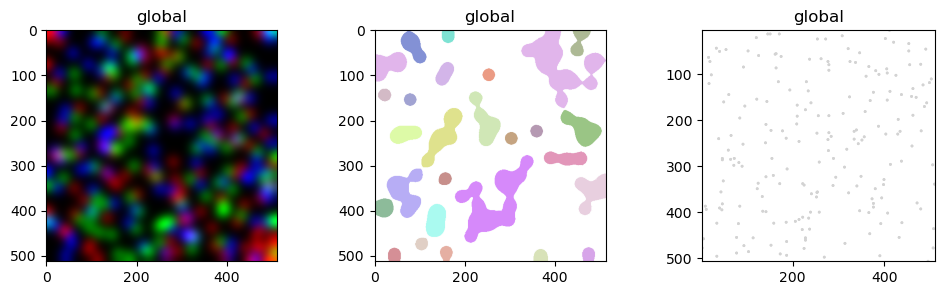

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

sdata.pl.render_images("blobs_image").pl.show(ax=axs[0])
sdata.pl.render_labels("blobs_labels").pl.show(ax=axs[1])
sdata.pl.render_points("blobs_points").pl.show(ax=axs[2])

We can do various type of aggregations:
- aggregate *images* by *labels*
- aggregate *points* by *shapes*
- aggregate *shapes* by *shapes*

Aggregations between mixed raster and non-raster types are currently not supported (but will be).

The API function for aggregation is `spatialdata.aggregate`. It is also possible to perform aggregation using the convenience method `spatialdata.SpatialData.aggregate`, which simply calls the previous one and automatically fills some values (`values_sdata` and `by_sdata`) with `self`; we will see this below.

Let's start with aggregation of *images* by *labels*. This can be achieved with one line of code:

## Aggregating images by labels

In [6]:
sdata_im = sdata.aggregate(values="blobs_image", by="blobs_labels", agg_func="mean")

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:260: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(table, region=shapes_name, region_key=region_key, instance_key=instance_key)


As default, the aggregation function is `sum` but it can be changed with the `agg_func` parameter. We can inspect the table inside the returned `SpatialData` object to confirm that the operation results in retrieving the mean intensity of each image channel within the boundaries of the labels.
We can also visualize the results with `spatialdata-plot`. By overlaying the labels with the channel where we performed aggregation, we can better appreciate the results. Labels that overlap with high intensity of the channels have indeed a higher mean intensity.

The features of the new table are the following:

In [7]:
sdata_im["table"].var_names

Index(['channel_0_mean', 'channel_1_mean', 'channel_2_mean'], dtype='object')

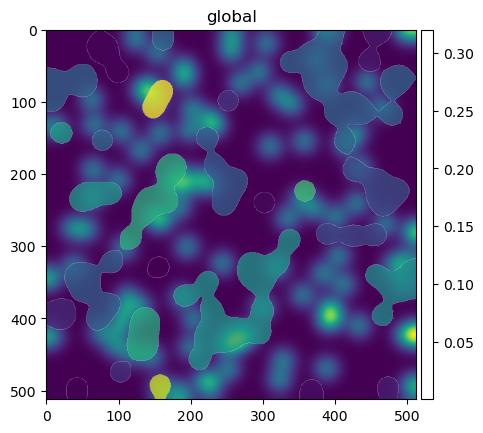

In [8]:
ax = plt.gca()
sdata.pl.render_images("blobs_image", cmap="viridis", channel=1).pl.show(ax=ax)
sdata_im.pl.render_labels(color="channel_1_mean", fill_alpha=0.5).pl.show(ax=ax)

We can also aggregate points by shapes. For example, let's count the number of points that overlap each shape.


Here we see the points and shapes that we will use for aggregation.

## Aggregating points by shapes

In [9]:
sdata["blobs_points"].compute()

,x,y,genes,instance_id
0,46,395,gene_b,9
1,334,224,gene_b,7
2,221,438,gene_b,3
3,44,356,gene_a,9
4,103,49,gene_b,4
...,...,...,...,...
195,381,92,gene_a,8
196,188,306,gene_b,5
197,368,447,gene_a,7
198,23,101,gene_a,6


/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:1895: UserWarning: No table found with color column genes to render blobs_points
  params = _validate_colors_element_table_mapping_points_shapes(sdata, params, wanted_elements_on_cs)
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:102: UserWarning: Key `blobs_points` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:692: FutureWarning: The

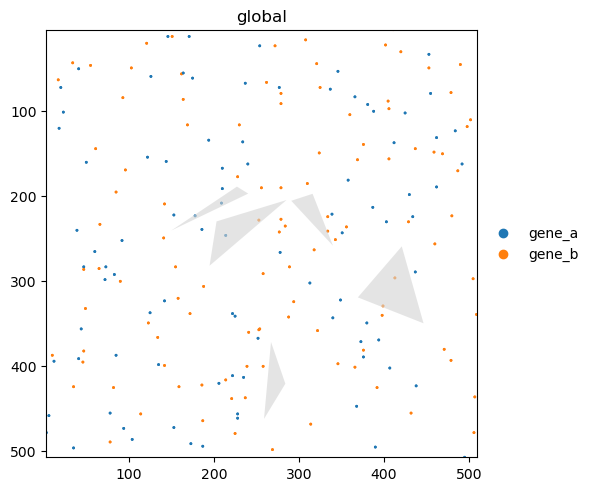

In [10]:
sdata.pl.render_points(color="genes").pl.render_shapes("blobs_polygons", fill_alpha=0.6).pl.show()

The `value_key` parameters specifies which columns of the points dataframe will be aggregated.

In [11]:
sdata_shapes = sdata.aggregate(values="blobs_points", by="blobs_polygons", value_key="genes", agg_func="count")
sdata_shapes

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:467: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated = joined.groupby([INDEX, vk])[ONES_COLUMN].agg(agg_func).reset_index()
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:260: UserWarning: Converting `region_key: region` to categorical dtype.

SpatialData object with:
├── Shapes
│     └── 'blobs_polygons': GeoDataFrame shape: (5, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (5, 2)
with coordinate systems:
▸ 'global', with elements:
        blobs_polygons (Shapes)

Let's color by the `var` value `gene_b` of the aggregate table (that is, we color by the numbers of points of type `gene_b` inside each shape).

/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:1895: UserWarning: No table found with color column genes to render blobs_points
  params = _validate_colors_element_table_mapping_points_shapes(sdata, params, wanted_elements_on_cs)
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:102: UserWarning: Key `blobs_points` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:692: FutureWarning: The

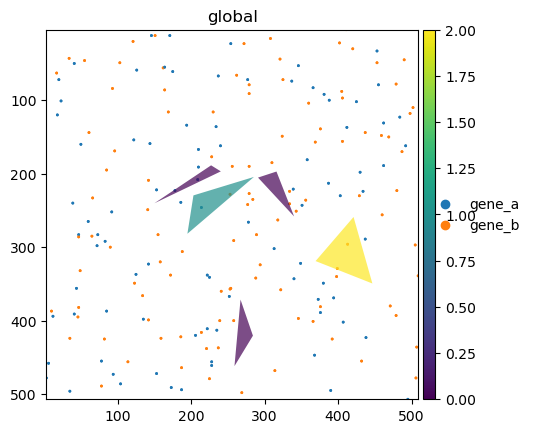

In [12]:
ax = plt.gca()
sdata.pl.render_points(color="genes").pl.show(ax=ax)
sdata_shapes.pl.render_shapes(color="gene_b", fill_alpha=0.7).pl.show(ax=ax)

The colormap represents the number of counts for the selected variable (gene "b"). The rightmost polygon has correctly a value of 2, as there are 2 transcripts (points) of type "b" overlapping the polygon area.

## Aggregating shapes by shapes, and information from different locations 

In this example let's show four things:
- aggregating shapes by shapes
- aggregating layers from different `SpatialData` objects
- aggregating signals from different location within the same `SpatialData` object (`value_key` parameter).
- explain the difference of the `aggregate()` function and the `aggregate()` method

To do so, let's create two `SpatialData` objects:
- one with the `blobs_circles` geometries, but adding some extra annotations, both as new `GeoDataFrame` columns, and in an `AnnData` table;
- one wiht two large rectangles that we will use to aggregate the circles by.

### Creating the circles object

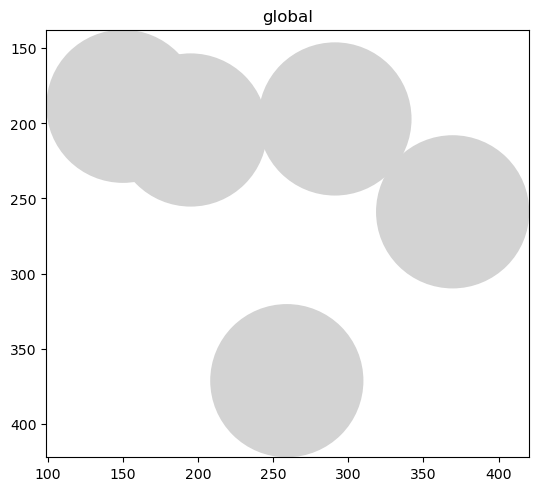

In [13]:
sdata.pl.render_shapes("blobs_circles").pl.show()

In [14]:
import numpy as np
import pandas as pd
from anndata import AnnData
from numpy.random import default_rng
from spatialdata import SpatialData
from spatialdata.models import TableModel

RNG = default_rng(42)

adata_circles = AnnData(
    RNG.normal(size=(5, 3)),
    var=pd.DataFrame(index=["gene_h", "gene_k", "gene_l"]),
    obs=pd.DataFrame(
        {
            "categorical": ["a", "a", "b", "c", "d"],
            "region": "blobs_circles",
            "instance_id": np.arange(5),
        }
    ),
)
adata_circles.obs["categorical"] = adata_circles.obs["categorical"].astype("category")
adata_circles.obs["region"] = adata_circles.obs["region"].astype("category")
adata_circles = TableModel.parse(adata_circles, region="blobs_circles", region_key="region", instance_key="instance_id")
sdata_circles = SpatialData(shapes={"blobs_circles": sdata["blobs_circles"]}, tables={"table": adata_circles})

# let's add two numerical columns to the GeoDataFrame
sdata_circles["blobs_circles"]["feature_m"] = RNG.normal(size=(5))
sdata_circles["blobs_circles"]["feature_n"] = RNG.normal(size=(5))

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:1895: UserWarning: No table found with color column feature_m to render blobs_circles
  params = _validate_colors_element_table_mapping_points_shapes(sdata, params, wanted_elements_on_cs)
/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:692: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


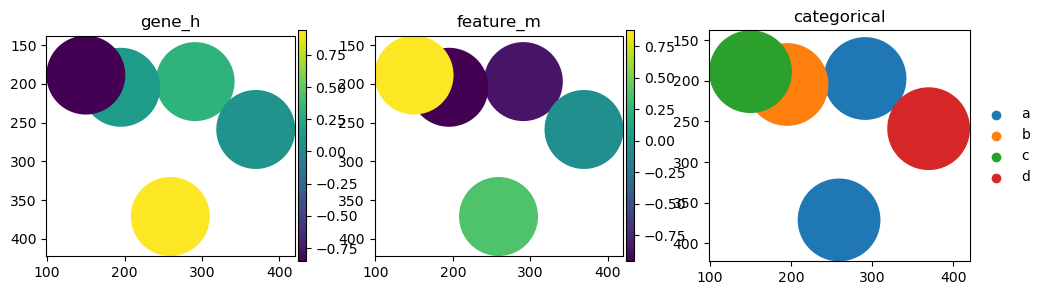

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(12, 3))
sdata_circles.pl.render_shapes(color="gene_h").pl.show(ax=axs[0], title="gene_h")
sdata_circles.pl.render_shapes(color="feature_m").pl.show(ax=axs[1], title="feature_m")
sdata_circles.pl.render_shapes(color="categorical").pl.show(ax=axs[2], title="categorical")

### Creating the squares object

In [16]:
import geopandas as gpd
from shapely import linearrings, polygons
from spatialdata.models import ShapesModel


def _make_squares(centroid_coordinates: np.ndarray, half_widths: list[float]) -> polygons:
    linear_rings = []
    for centroid, half_width in zip(centroid_coordinates, half_widths):
        min_coords = centroid - half_width
        max_coords = centroid + half_width

        linear_rings.append(
            linearrings(
                [
                    [min_coords[0], min_coords[1]],
                    [min_coords[0], max_coords[1]],
                    [max_coords[0], max_coords[1]],
                    [max_coords[0], min_coords[1]],
                ]
            )
        )
    s = polygons(linear_rings)
    polygon_series = gpd.GeoSeries(s)
    cell_polygon_table = gpd.GeoDataFrame(geometry=polygon_series)
    return ShapesModel.parse(cell_polygon_table)


sdata_squares = SpatialData(
    shapes={"squares": _make_squares(np.atleast_2d([[100, 200], [400, 200]]), half_widths=[100, 80])}
)

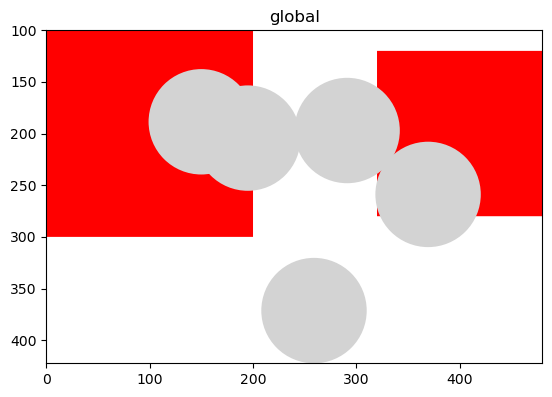

In [17]:
ax = plt.gca()

sdata_squares.pl.render_shapes("squares", na_color="red", alpha=0.5).pl.show(ax=ax)
sdata_circles.pl.render_shapes("blobs_circles", alpha=0.5).pl.show(ax=ax)

We will now aggregate the various quantities. Notice how the `value_key` can be used to aggregate values that are located in different places in the `SpatialData` object:
1. matrix `X` of the `AnnData` table (names given by `.var_names`);
2. `.obs` `DataFrame` of the `AnnData` table;
3. columns of the `GeoDataFrame`.

Notice also that the API deal both with numerical and categorical values, and can aggregate multiple numerical columns at the same time.

#### Case: `value_key` referring to `var_names`

In [18]:
from spatialdata import aggregate

sdata_gene_exp = aggregate(
    values_sdata=sdata_circles,
    by_sdata=sdata_squares,
    values="blobs_circles",
    by="squares",
    value_key=["gene_h", "gene_k"],
    table_name="table",
)
print(sdata_gene_exp)
print()
print(sdata_gene_exp["table"].var_names)

SpatialData object with:
├── Shapes
│     └── 'squares': GeoDataFrame shape: (2, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (2, 2)
with coordinate systems:
▸ 'global', with elements:
        squares (Shapes)

Index(['gene_h', 'gene_k'], dtype='object')


/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:260: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(table, region=shapes_name, region_key=region_key, instance_key=instance_key)


#### Case: `value_key` referring to `GeoDataFrame` columns

In [19]:
sdata_feature = aggregate(
    values_sdata=sdata_circles,
    by_sdata=sdata_squares,
    values="blobs_circles",
    by="squares",
    value_key="feature_m",
)
print(sdata_feature)
print()
print(sdata_feature["table"].var_names)

SpatialData object with:
├── Shapes
│     └── 'squares': GeoDataFrame shape: (2, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (2, 1)
with coordinate systems:
▸ 'global', with elements:
        squares (Shapes)

Index(['feature_m'], dtype='object')


/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:260: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(table, region=shapes_name, region_key=region_key, instance_key=instance_key)


#### Case: `value_key` referring to `obs` columns

In [20]:
sdata_categorical = aggregate(
    values_sdata=sdata_circles,
    by_sdata=sdata_squares,
    values="blobs_circles",
    by="squares",
    value_key="categorical",
)
print(sdata_categorical)
print()
print(sdata_categorical["table"].var_names)

SpatialData object with:
├── Shapes
│     └── 'squares': GeoDataFrame shape: (2, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (2, 4)
with coordinate systems:
▸ 'global', with elements:
        squares (Shapes)

Index(['a', 'b', 'c', 'd'], dtype='object')


/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:467: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated = joined.groupby([INDEX, vk])[ONES_COLUMN].agg(agg_func).reset_index()
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:260: UserWarning: Converting `region_key: region` to categorical dtype.

/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:692: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


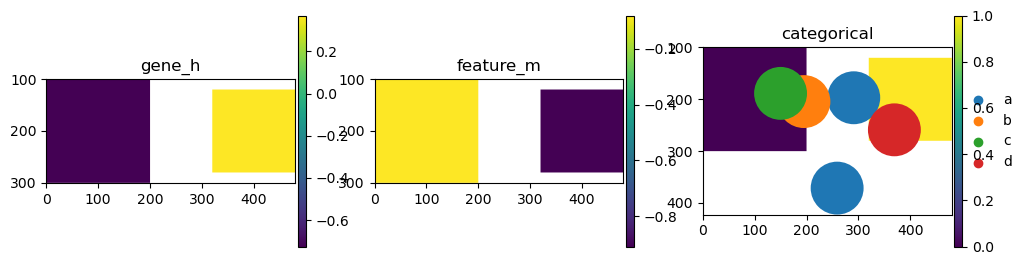

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

sdata_gene_exp.pl.render_shapes("squares", color="gene_h", alpha=0.5).pl.show(ax=axs[0], title="gene_h")

sdata_feature.pl.render_shapes("squares", color="feature_m", alpha=0.5).pl.show(ax=axs[1], title="feature_m")

sdata_categorical.pl.render_shapes("squares", color="a", alpha=0.5).pl.show(ax=axs[2], title="categorical")
sdata_circles.pl.render_shapes(color="categorical").pl.show(ax=axs[2], title="categorical")

### The method vs the function

Above we used the `aggregate()` function. The method version is equivalent and it is a convenience function that simply fills in eventually missing values of `values_sdata` and `by_sdata` with `self`.

So these two functions are equivalent:

In [22]:
res0 = aggregate(
    values_sdata=sdata_circles,
    by_sdata=sdata_squares,
    values="blobs_circles",
    by="squares",
    value_key="feature_m",
)

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:260: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(table, region=shapes_name, region_key=region_key, instance_key=instance_key)


In [23]:
res1 = sdata_circles.aggregate(
    by_sdata=sdata_squares,
    values="blobs_circles",
    by="squares",
    value_key="feature_m",
)

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:260: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(table, region=shapes_name, region_key=region_key, instance_key=instance_key)


One can also directly pass to `values` or `by` a `SpatialElement`. So also this is an equivalent call, except for the fact that now the string `squares` is never passed to `aggregate()`, so it will be used a default name for the name of the `SpatialElement`

In [24]:
res2 = sdata_circles.aggregate(
    by=sdata_squares["squares"],
    values="blobs_circles",
    value_key="feature_m",
)

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:260: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(table, region=shapes_name, region_key=region_key, instance_key=instance_key)


In [25]:
from anndata.tests.helpers import assert_equal

assert_equal(res0["table"], res1["table"])
assert_equal(res0["table"].X, res2["table"].X)

In [26]:
res0["table"].obs

,instance_id,region
0,0,squares
1,1,squares


In [27]:
res2["table"].obs

,instance_id,region
0,0,by
1,1,by
